## Instructions

- See deadline on the course web page
- This project is performed in groups of two students. 
- The second part of the project is optional. See examination rules on the course web page.
- Hand-in your written report and your solution source code via Canvas. 
- Please also upload your ANN model with the trained parameters as `myNN.keras` using the keras `save_model` method: `tf.keras.models.save_model(model, 'myNN.keras')`, which employs the native Keras file format.

### Written report
- Page limit: 6 pages (excluding title page and list of references). 3 extra pages are allowed when doing also the optional extra task.
- Give a short description of the nature of the problem and the methods you have used.
- Include your results either in figure form or in a table. All tables and figures should have relevant captions and labels on the axes.
- Try to give an interpretation of you results.
- Upload the source code of your program as a separate file (.ipynb or .py). Comment your program properly.

### Learning goals:
* Apply deep neural networks to build an emulator for a physics problem that is difficult and costly to solve numerically.
* Get familiar with [tensorflow](https://www.tensorflow.org/), the popular open-source library to train ML models created by the Google Brain team.
* Get experience with some diagnostics used in the training of neural networks. 
* Understand the difficulties and choices involved when training a deep neural network.
* This is a less-guided set of tasks and you will have to put together ideas and tools we've discussed.
* Reproduce scientific results from a published paper.

## Main task
The overall project goal is to reproduce various results in a paper: [*Newton vs the machine: solving the chaotic three-body problem using deep neural networks*](https://arxiv.org/abs/1910.07291) by Philip G. Breen, Christopher N. Foley, Tjarda Boekholt, Simon Portegies Zwart.

The authors have graciously agreed that we use the raw data from their study for this project (but please don't distribute any further).

### Physical problem

In this project we are studying the motion of three bodies of equal mass that move under the mutual influence of classical gravitational forces. Due to the system's chaotic nature, the solution to this problem for a given initialization can only be found by performing iterative numerical calculations that have potentially very large computational cost. 

Here you will demonstrate that a deep artificial neural network (ANN) is able to learn the solutions to the equations of motion from a set of numerical training data. This ANN can then provide good approximations for new initial conditions at a predictable (and small) computational cost.

The training data that we will be using was generated with a state-of-the-art numerical code `Brutus` [[Boekholt, T., Portegies Zwart, S. On the reliability of N-body simulations. Comput. Astrophys. 2, 2 (2015).](https://doi.org/10.1186/s40668-014-0005-3)]. The run time of that code for the trajectories studied here ranges from minutes up to hours. In the end, it will therefore be relevant to quantify what is the computational cost of making a prediction with our constructed ANN.

### Initial condition and choice of coordinates
- We work in the the center-of-mass (CM) frame and only consider the scenario in which the three masses start from rest.
- It can be shown that, without loss of generality, it is always possible to choose a coordinate system such that the three particles $p_1, p_2, p_3$ move in a plane so that just $(x,y)$ coordinates are needed.
- Furthermore, the $(x,y)$ coordinates can be chosen and scaled such that particle 1 starts in position $(1,0)$ and the initial position of particle 2 is located in the second quantile ($x<0$, $y>0$).
- Since we are in the CM frame and our system consists of three equal masses we will always have $x_1+x_2+x_3=0$ and $y_1+y_2+y_3=0$. Consequently, we can determine the position of particle 3 from knowledge of the positions of particles 1 and 2.

See also Fig. 1 in the paper.

### Data
The data that you should use is made available as a compressed numpy file on the Canvas course page. Note that, due to its size, it is not included in the `tif285` git repo.

Navigate to Files > Project2  and download `data_project2.npz` into your work directory.

In [1]:
# Load modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Add your own import statements if needed
import sklearn.model_selection

In [2]:
# Load and unpack a compressed npy array
load_data = np.load('data_project2.npz')
data = load_data['arr_0']
print(data.shape)

(9000, 1000, 9)


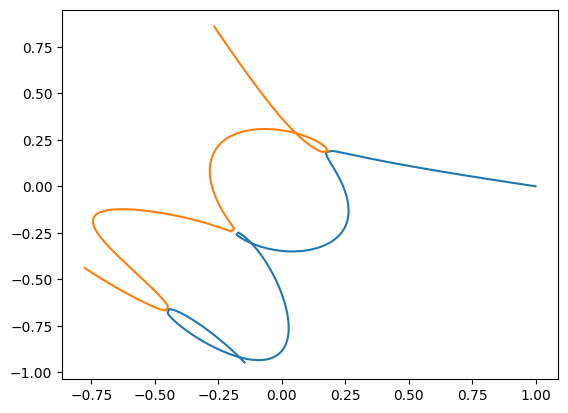

In [3]:

plt.plot(data[0,:,1], data[0,:,2])
plt.plot(data[0,:,3], data[0,:,4])


- The first axis labels the 9000 data samples.
- The second axis is the 1000 time steps, which corresponds to 3.9 time units. The original data is composed of 2561 time steps, reaching 10 time units, but as discussed in the paper the training of the ANN works better for the somewhat shorter time interval.
- The nine columns of the last axis correspond to: $[t, x_1, y_1, x_2, y_2, v_{x,1}, v_{y,1}, v_{x,2}, v_{y,2}]$ (note again that the position of particle 3 can be obtained from the positions of particles 1 and 2). The velocity data is only used in the extra task.
- Some of the trajectories contain collisions such that the positions of the particles get stuck at (0, 0). Check the data to find those trajectories and remove them before training your model.
- Note that the trajectories are represented by data points in sets of 1000 (time steps). While creating batches of data, make sure you are not splitting data from one trajectory into different batches.

### List of tasks
1. Download and load the pre-trained ANN from the paper (see below) and construct/train your own ANN using the provided data. Compare the complexity (number of trainable parameters) in the pre-trained versus your own ANN.
1. Show the Mean Absolute Error (MAE) vs epoch from the training of your own ANN (as in Fig. 3 of the paper). I.e. you should show both the MAE metric on the training and the validation data.
1. Check the accuracy of the pre-trained ANN by visually comparing some trajectories with the ANN predictions as in Fig. 4 of the paper. Add also the trajectory of your ANN and comment on its performance. (Note that you should not expect your own ANN to perform as well as the pre-trained one. In addition, the trajectories that are shown in the paper seem to be ones for which the model works very well).
1. Check the computational cost of making a prediction with the ANN. You will find that it is much shorter than the numerical integration performed by `Brutus` (which according to the reference takes minutes to hours for finding a trajectory).
1. Having access to these ANN emulators you can explore the chaotic aspect of this motion by creating a hundred different trajectories from a slightly disturbed initial condition. Try to reproduce Fig. 5 in the paper (both with the pre-trained and your own ANN).

### Suggestions for how to proceed:
* Follow the lead of the demo notebook for using tensorflow / keras (plus see the hints below).
* First download and load the data set and the ANN from the paper (both available on the Canvas course page. Navigate to Files > Project2; see hint below)
* It is suggested (but not required) to create helper functions (see hints below): 
  * `get_data` for extracting a trajectory (positions of particle 1 as a function of the discrete time) from the data; 
  * `get_trajectories` for generating the positions of all particles from a prediction output that contains the arrays of the first two particles' positions; 
  * `plot_trajectories` for plotting a trajectory.
* When creating your own ANN it is suggested that you first design a smaller one than in the paper (e.g., using five dense layers with 64 neurons in each) and analyse how it performs by looking at the training vs validation error. The creation of a large network with ten layers and 128 nodes per layer is optional (and might require more cpu-hours for training).
* Try first with the `relu` activation function and the `Adam` optimizer with a learning rate of 0.001 and moments of 0.5 (these hyper-parameters can easily be changed if you want; see hints below). 
    - The choice of optimizer  and hyper-parameters such as learning rate can certainly influence your results. For the interested, an extensive guide with open-source experimental results is published here: https://arxiv.org/abs/2007.01547.
* Use 90% of the data for training and 10% for validation. You probably need at least hundred epochs for training and it is suggested to split the data into 10-100 batches (see hints below).

### Comments and hints
* Download the pre-trained ANN model `Breen_NN_project2.keras` and load it with: `pre_trained_model = keras.models.load_model("Breen_NN_project2.keras")`. This file should also be included in the gzipped tarball that contains the project 2 files.
  *Please let us know if you have difficulties loading this model as there might be compatibility issues between different `tensorflow` versions. As a backup, the weights of Breen's model are stored in `Breen_NN_project2.weights.h5` and can be loaded using the `load_weights()` method into a network of the correct topology (10 hidden layers of width 128; relu activation).*
* The ANN input should be an array with three elements: $[t,x_2,y_2]$, where the last two will be the initial position of particle 2 and the first one is the time step for which the particle positions should be predicted. Remember that particle 1 always starts in $(1,0)$. 
* Input data corresponding to a single trajectory is then of shape $1000 \times 3$ where the first column contains the time steps while the $x_2,y_2$ columns are repetitions of the initial position.
* I.e., the inputs to the `tensorflow` network is a tensor with three columns where the second and third columns have values that are repeated (with values of the initial position at [t=0]) for all the rows corresponding to a single trajectory.
* The output should be an array with four elements $[x_1,y_1,x_2,y_2]$ that corresponds to the positions of particles 1 and 2 at the time step $t$ that was given in the first position of the input. Again, we can consider a tensor (batch) of outputs corresponding, e.g., to a full trajectory.
* As mentioned, some of the trajectories contain collisions such that the positions of the particles get stuck at (0, 0). Check the data to find those trajectories and remove them before training your model.
* The data can be turned into a `tensorflow` dataset using: `dataset = tf.data.Dataset.from_tensor_slices((x, y))`, where `x` and `y` are input and output data, respectively (you might possibly need to reshape using `x.reshape(-1, 3)` and `y.reshape(-1, 4)`)
* Having created a dataset, e.g. `train_dataset`, you can make batches (e.g. with batchsize 5000) with `train_dataset = train_dataset.batch(5000)`. The same should then be done for the validation data. As mentioned, the trajectories are represented by data points in sets of 1000 (time steps). While creating batches of data, make sure you are not mixing part of the data from one trajectory with a different trajectory. 
* When compiling a `tensorflow` model, with `model.compile()`, the Adam optimizer can be specified via the argument `optimizer=keras.optimizers.Adam(0.001, 0.5, 0.5)`
* Furthermore, the loss function can be chosen using the argument `loss=keras.losses.MeanAbsoluteError()`
* Fitting the model for 100 epochs with specified training and validation data sets can be performed with: `model.fit(train_dataset, epochs=100, validation_data = val_dataset)`
* Given the cost of training the network with all data, it is not required to make extensive tests of tuning the hyperparameters.
* More exact timing of a function can be measured using ["Jupyter notebook magic"](https://towardsdatascience.com/the-top-5-magic-commands-for-jupyter-notebooks-2bf0c5ae4bb8) by putting the command to be measured in a notebook cell that starts with `%timeit`. This will run the cell many times and report the mean and standard deviation of the evaluation time.

#### Helper function docstrings
The following are just suggestions. You are allowed to construct a solution using your own helper functions.

In [4]:
def get_data(idx):
    """
    Get one training instance from the data set at the index idx. 
    
    The data is assumed to be in an array `data`.
    
    Args:
        idx (int): An integer specifying which of the training example to fetch
        
    Returns:
        x (array): An array of shape (time_steps, 3) which specifies the input to
                   the neural network. The first column is the time and the second
                   and third columns specify the (x, y) coordinates of the second
                   particle. Note that the first particle is always assumed to be
                   at (1, 0) and the third particle can be inferred from the first
                   and second particle's position.
                   
        y (array): An array of shape (time_steps, 4) which specifies the output that 
                   is expected from the neural network.
                   
                   The first two columns specify the (x, y) coordinates of the first
                   particles and the next two columns give the coordinates of the 
                   second particle for the specified time (length of the columns).
                   The third particles position can be inferred from the first
                   and second particle's position.
    """
    x = np.array([data[idx, 1:, 0], np.zeros_like(data[idx, 1:, 0]) + data[idx, 0, 3], np.zeros_like(data[idx, 1:, 0]) + data[idx, 0, 4]]).T
    y = np.array([data[idx, 1:, 1], data[idx, 1:, 2], data[idx, 1:, 3], data[idx, 1:, 4]]).T
    
    return x, y

(999, 3)
(999, 4)


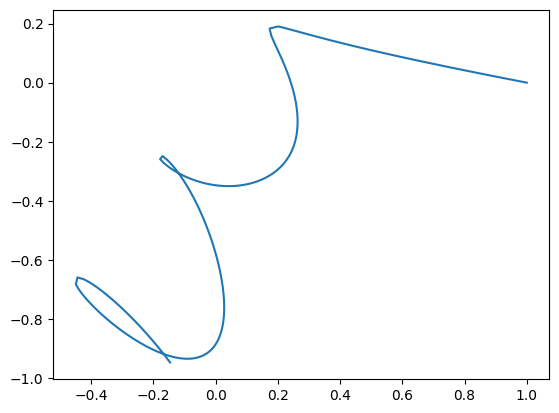

In [5]:
x, y = get_data(0)
print(x.shape)
print(y.shape)
plt.plot(y[:,0], y[:,1])

In [6]:
def get_trajectories(pred):
    """
    Gets the trajectories from a predicted output pred.
    
    Args:
        pred (array): An array of shape (N, 4) where N is the number of time
                      steps. The four columns give the positions of the particles
                      1 and 2 for all the time steps.
    Returns:
        p1, p2, p3 (tuple of arrays): Three arrays of dimensions (N, 2) where N is the number 
                             of time steps and the two columns for each array give 
                             the positions of the three particles (p1, p2, p3)
    """
    p1 = np.array([pred[:, 0], pred[:, 1]]).T
    p2 = np.array([pred[:, 2], pred[:, 3]]).T
    p3 = - p1 - p2
    
    return p1, p2, p3

In [7]:
def plot_trajectories(p1, p2, p3, ax=None, **kwargs):
    """
    Plots trajectories for points p1, p2, p3
    
    Args:
        p1, p2, p3 (array): Three arrays each of shape (n, 2) where n is the number
                            of time steps. Each array is the (x, y) position for the
                            particles
        ax (axis object): Default None, in which case a new axis object is created.
        kwargs (dict): Optional keyword arguments for plotting
        
    Returns:
        ax: Axes object
    """

    if ax == None:
        fig, ax = plt.subplots(1,1,)

    # Plot starting points
    ax.plot(p1[0, 0], p1[0, 1], 'or')
    ax.plot(p2[0, 0], p2[0, 1], 'ob')
    ax.plot(p3[0, 0], p3[0, 1], 'og')

    # Plot trajcetories
    ax.plot(p1[:, 0], p1[:, 1], 'r', **kwargs)
    ax.plot(p2[:, 0], p2[:, 1], 'b', **kwargs)
    ax.plot(p3[:, 0], p3[:, 1], 'g', **kwargs)


    return ax

(999, 3)
(999, 2) (999, 2) (999, 2)


<Axes: >

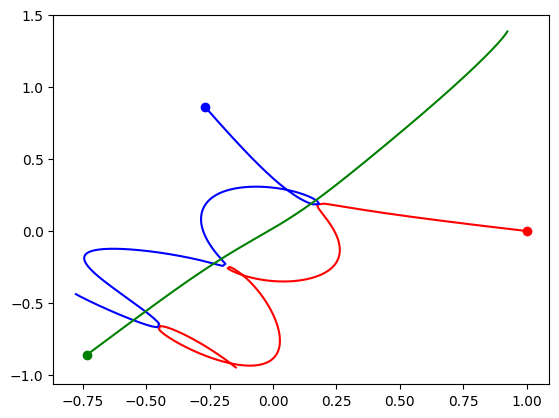

In [8]:
# Test help functions
x, y = get_data(0)

print(x.shape)



p1, p2, p3 = get_trajectories(y)

print(p1.shape, p2.shape, p3.shape)


plot_trajectories(p1, p2, p3)

In [9]:
# Load pre-trained model
pre_trained_model = keras.models.load_model("Breen_NN_project2.keras")

In [10]:
pre_trained_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,636 (1.14 MB)

 Trainable params: 149,636 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<Axes: >

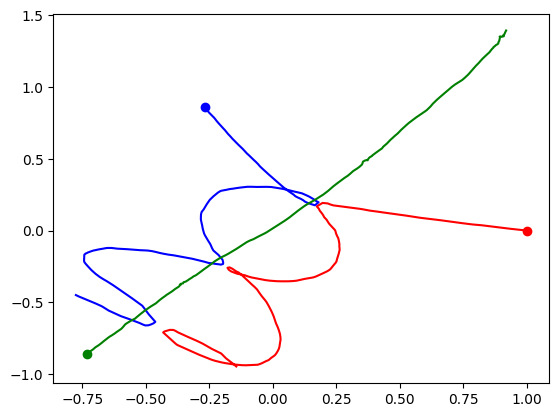

In [11]:
# Test pre-trained model
pre_trained_y = pre_trained_model.predict(x)
p1, p2, p3 = get_trajectories(pre_trained_y)
plot_trajectories(p1, p2, p3)

In [12]:
# Clean data (remove collisions)
index_to_delete = []
for i in range(data.shape[0]):
    x, y = get_data(i)
    if y[-1].all() < 0.01:
        index_to_delete.append(i)

In [13]:
print(data.shape)
print(len(index_to_delete))
data_clean = np.delete(data, index_to_delete, axis=0)
print(data_clean.shape)
print(data_clean.shape[0]+len(index_to_delete))

(9000, 1000, 9)
1377
(7623, 1000, 9)
9000


In [14]:
# Create dataset
train_data, test_data = sklearn.model_selection.train_test_split(data_clean, test_size=0.1, random_state=5)


In [15]:
print(train_data.shape[0] / (test_data.shape[0] + train_data.shape[0]))
print(train_data.shape)


0.8999081726354453
(6860, 1000, 9)


In [161]:
# Fix train data
X_train = []
Y_train = []
for i in range(int(train_data.shape[0]/10)):
    x, y = get_data(i)
    X_train.append(x)
    Y_train.append(y)

X_train = np.array(X_train).reshape(-1, 3)
Y_train = np.array(Y_train).reshape(-1, 4)


dataset_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))



In [162]:
# Fix test data
X_test = []
Y_test = []
for i in range(int(test_data.shape[0]/10)):
    x, y = get_data(i)
    X_test.append(x)
    Y_test.append(y)



X_test = np.array(X_test).reshape(-1, 3)
Y_test = np.array(Y_test).reshape(-1, 4)


dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [163]:
# Batch the datasets
dataset_train = dataset_train.batch(999*5)
dataset_test = dataset_test.batch(999*5)

In [19]:
# Create own ANN
model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(3,)),
        tf.keras.layers.Dense(64, activation='relu',),
        tf.keras.layers.Dense(64, activation='relu',),
        tf.keras.layers.Dense(64, activation='relu',),
        tf.keras.layers.Dense(64, activation='relu',),
        tf.keras.layers.Dense(64, activation='relu',),
        tf.keras.layers.Dense(4, activation='linear',)
    ])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,156 (67.02 KB)

 Trainable params: 17,156 (67.02 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer= keras.optimizers.Adam(0.001, 0.5, 0.5),
                loss=keras.losses.MeanAbsoluteError(),
                metrics=['accuracy'])

In [22]:
# Train model
history = model.fit(dataset_train, epochs=100, validation_data = dataset_test)

Epoch 1/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5924 - loss: 0.2567 - val_accuracy: 0.7023 - val_loss: 0.1788
Epoch 2/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.7301 - loss: 0.1606 - val_accuracy: 0.7458 - val_loss: 0.1440
Epoch 3/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.7576 - loss: 0.1390 - val_accuracy: 0.7314 - val_loss: 0.1293
Epoch 4/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.7614 - loss: 0.1266 - val_accuracy: 0.7448 - val_loss: 0.1262
Epoch 5/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7690 - loss: 0.1193 - val_accuracy: 0.7396 - val_loss: 0.1209
Epoch 6/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.7786 - loss: 0.1141 - val_accuracy: 0.8309 - val_loss: 0.1100
Epoch 7/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.7801 - loss: 0.1100 - val_accuracy: 0.7613 - val_loss: 0.0996
Epoch 8/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 

In [23]:
# Save model
tf.keras.models.save_model(model, 'myNN1024.keras')

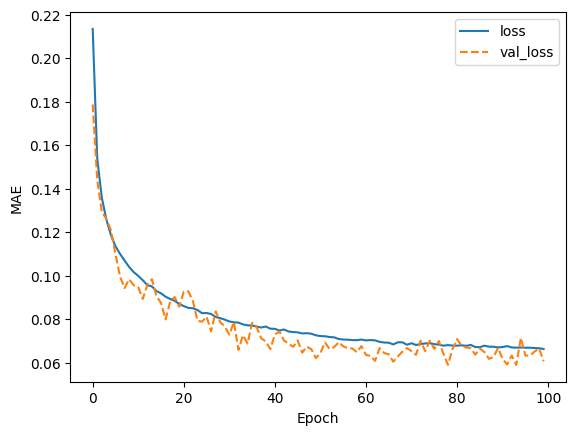

In [24]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[ 1.0123671  -0.0076818  -0.27101874  0.8585911 ]
 [ 1.0150282  -0.00517523 -0.27422068  0.8670892 ]
 [ 1.0147074  -0.00496139 -0.27450365  0.8669425 ]
 ...
 [-0.19470377 -0.99136525 -0.7487186  -0.49170196]
 [-0.1936378  -0.9923734  -0.74974877 -0.49141693]
 [-0.19257407 -0.9933799  -0.7507769  -0.49113286]]


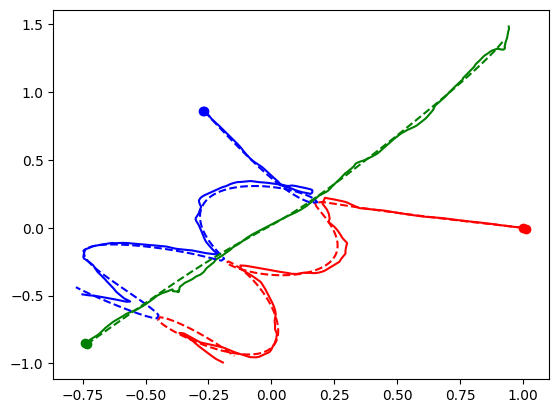

In [25]:

x, y = get_data(0)
model_y = model.predict(x)
p1, p2, p3 = get_trajectories(model_y)
ax = plot_trajectories(p1, p2, p3, linestyle= 'solid')
p1, p2, p3 = get_trajectories(y)
plot_trajectories(p1, p2, p3, ax=ax, linestyle='dashed')

print(model_y)

In [26]:
# Bigger ANN
big_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(3,)),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(4, activation='linear',)
    ])

big_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,636 (584.52 KB)

 Trainable params: 149,636 (584.52 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
big_model.compile(optimizer= keras.optimizers.Adam(0.001, 0.5, 0.5),
                loss=keras.losses.MeanAbsoluteError(),
                metrics=['accuracy'])

In [28]:
big_history = big_model.fit(dataset_train, epochs=100, validation_data = dataset_test)

Epoch 1/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 64s 44ms/step - accuracy: 0.6071 - loss: 0.2589 - val_accuracy: 0.7833 - val_loss: 0.1968
Epoch 2/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 59s 43ms/step - accuracy: 0.7280 - loss: 0.1649 - val_accuracy: 0.6942 - val_loss: 0.1611
Epoch 3/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 70s 51ms/step - accuracy: 0.7444 - loss: 0.1481 - val_accuracy: 0.7730 - val_loss: 0.1229
Epoch 4/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 59s 43ms/step - accuracy: 0.7621 - loss: 0.1349 - val_accuracy: 0.8353 - val_loss: 0.1243
Epoch 5/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - accuracy: 0.7672 - loss: 0.1282 - val_accuracy: 0.8018 - val_loss: 0.1608
Epoch 6/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 58s 42ms/step - accuracy: 0.7732 - loss: 0.1200 - val_accuracy: 0.7643 - val_loss: 0.1165
Epoch 7/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - accuracy: 0.7796 - loss: 0.1140 - val_accuracy: 0.8811 - val_loss: 0.0935
Epoch 8/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 58s 42ms/step - accuracy: 

In [29]:
# Save big model
tf.keras.models.save_model(big_model, 'mybigNN1024.keras')

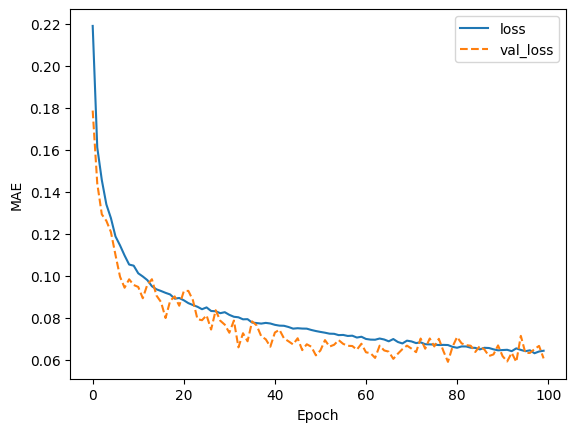

In [30]:
plt.plot(big_history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


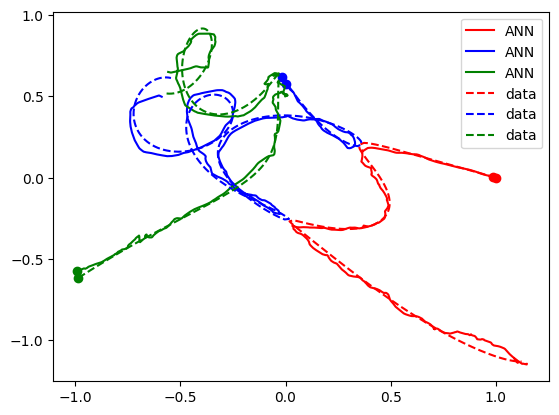

In [88]:
x, y = get_data(1337)
big_model_y = big_model.predict(x)
p1, p2, p3 = get_trajectories(big_model_y)
ax = plot_trajectories(p1, p2, p3, linestyle= 'solid', label='ANN')
p1, p2, p3 = get_trajectories(y)
plot_trajectories(p1, p2, p3, ax=ax, linestyle='dashed', label='data')
ax.legend()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

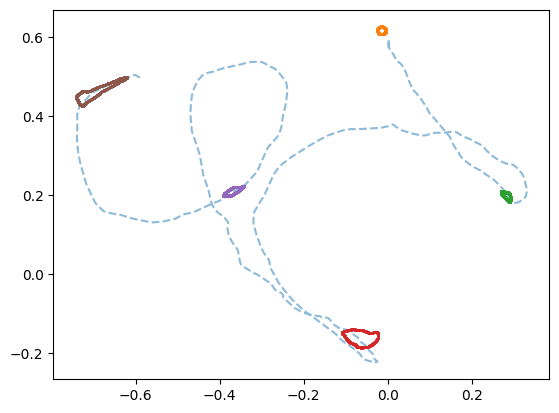

In [89]:
# Small variations in input (fig. 5 in paper)
r = 0.01
t = np.array([0.95, 1.9, 2.95, 3.8])
num = 1000

x0 = x[0, 1:]
x0new = np.zeros_like(x0)
pos = np.zeros([num, 5, 2])


for i in range(num):
    angle = np.random.rand() * 2 * np.pi
    x0new[0] = x0[0] + r*np.cos(angle)
    x0new[1] = x0[1] + r*np.sin(angle)

    pos[i, 0] = x0new
    input = np.zeros((4, 3))
    input[:,0] = t
    input[:,1:] = np.zeros([4, 2]) + x0new
    

    y_pred = big_model.predict(input)
    pos[i, 1:, :] = y_pred[:, 2:]

plt.plot(big_model_y[:, 2], big_model_y[:, 3], '--', alpha = 0.5)
plt.plot(pos[:, :, 0], pos[:, :, 1], '.', markersize= 2)


In [32]:
# Träna på hela datan
# Utervera hastighet av prediction med timeit
# Skapa figurer som dem i pappret (med helt tränade modeller)
# Hitta våra bästa trajectory plots
# Kolla in det där kaotiska (fig 5 i papper)

## Optional: Part 2 (extra task)
* Create a helper function that extracts the velocity at each time step.
* Compute the potential energy and the kinetic energy at each time step. The units are chosen such that the total energy is just the sum of these two.
* Check for the conservation of energy in: (i) the data generated by `Brutus` (note that the velocities are given in the last few columns of the data file); (ii) the pre-trained model from the paper; (iii) your ANN model.
* Create a custom loss function and re-train your model to be trained (constrained) by energy conservation. (Unfortunately, you should not expect any significant improvement in the model with the energy-conserving loss function.)
* Reproduce Fig. 6 (with the green line being replaced by your energy-conserving ANN). 

### Comments and hints

* You should probably define helper functions that compute potential energies, velocities and kinetic energies for points along a trajectory. Note that the masses start from rest.
* In order to construct a `tensorflow` custom loss you will need `@tf.function()` versions of the same helper functions. Within these you can only use `tensforflow` methods such as: `tf.concat()` and `tf.math.sqrt()` (i.e., `numpy` methods cannot be used for these functions). 
* See (suggested) `tensorflow` helper functions docstrings below. 
* You can define a **custom loss function** that assumes a batch size that is equal to the number of time steps in a trajectory. You should also make sure that the data is not shuffled so that a **batch always corresponds to a trajectory**. Then you can use a **global time array** to be used to extract velocities and therefore kinetic energies.
* See a suggested structure of the custom loss below. You might get problems with very large kinetic and potential energies for trajectories with close encounters. A suggestion is to clip very large values of `energy_error` in the return statement of the custom energy loss by `tf.clip_by_value(energy_error, -1e6, 1e6)`. 
* The custom loss is then used in `model.compile()` via the argument `loss=custom_energy_loss`.

#### Helper function docstrings
The following are just suggestions. You are allowed to construct a solution using your own helper functions.

In [253]:
import tensorflow as tf
from tensorflow import keras

@tf.function()
def tf_ediff1d(a):
    """
    TensorFlow equivalent of 1D difference.
    
    Args:
        a (array): A TensorFlow array of dimension (N, 1)
        
    Returns:
        diff (array): An array which gives the difference of successive elements of a.
    """
    diff = [a[1]- a[0]]
    for i in range(len(a)-1):
        diff.append(a[i+1] - a[i])
    return tf.cast(diff, float)

@tf.function()
def tf_compute_velocities(t, p):
    """
    Computes the velocities of the particles from the trajectories starting from rest.
    
    Args:
        t (array[float]): An array of shape (N, 1) giving time steps.
        p (array): An array of dimension (N, 2) where N is the number 
                   of time steps and the two columns give the coordinates
                   of the particle.
                             
    Returns:
        v (array): An array of dimension (N, 2) where N is the number 
                   of time steps and the two columns for each array give 
                   the x and y components for the instantaneous velocity
                   of the particle.
    """
    dx = tf_ediff1d(p[:, 0])
    dy = tf_ediff1d(p[:, 1])
    dt = tf_ediff1d(t)
    
    vx = tf.math.divide(dx, dt)
    vy = tf.math.divide(dy, dt)

    v = [vx, vy]

    return v

@tf.function()
def tf_compute_kinetic_energy(v):
    """
    Computes the kinetic energy for the given velocity vectors
    
    Args:
        v (array): A (N,2) array of veolcities for N time steps.
        
    Returns:
        ke (array): An array of shape (N, 1) giving the kinetic energies at each time step.
    """
    
    ke = tf.math.divide(tf.experimental.numpy.power(tf.norm(v, axis=0),2),2)
    return tf.cast(ke, float)

@tf.function()
def tf_compute_potential_energy(p1, p2, p3):
    """
    Computes the potential energy for the given position vectors. The value of the 
    gravitational constant is taken as 1 (G=1). The masses are the same value (m=1)
    
    Args:
        p1, p2, p3 (tuple of arrays): Three arrays of dimensions (N, 2) where N is the number 
                             of time steps and the two columns for each array give 
                             the positions of the three particles (p1, p2, p3)
                             
    Returns
        pe (array): An array of shape(N, 1) giving the potential energy at each time step
        
    """
    pe = []
    if p1.shape == (2,):
        pe12 = tf.math.divide(1, tf.norm(p1-p2))
        pe13 = tf.math.divide(1, tf.norm(p1-p3))        
        pe23 = tf.math.divide(1, tf.norm(p2-p3))
        pe = pe12 + pe13 + pe23
    else:
        
        pe12 = tf.math.divide(1, tf.norm(p1-p2, axis=1))
        pe13 = tf.math.divide(1, tf.norm(p1-p3, axis=1))        
        pe23 = tf.math.divide(1, tf.norm(p2-p3, axis=1))

        pe = pe12+pe13+pe23
    return tf.cast(pe, float)

In [119]:
a = [1.0, 2.0, 5.5]
print(tf_ediff1d(a))

[<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=3.5>]


In [128]:
a = tf.constant([[1,20,5],[1,2,5]])
t = tf.constant([1, 2, 3])
v= tf_compute_velocities(t,a)
ke = tf_compute_kinetic_energy(v)
print(ke)

tf.Tensor(212.7369267428671, shape=(), dtype=float64)


In [176]:
pe = tf_compute_potential_energy(p1, p2, p3)

In [177]:
print(pe)

[<tf.Tensor: shape=(), dtype=float64, numpy=1.959859094357729>, <tf.Tensor: shape=(), dtype=float64, numpy=1.9598990213983052>, <tf.Tensor: shape=(), dtype=float64, numpy=1.959965571796671>, <tf.Tensor: shape=(), dtype=float64, numpy=1.9600587535509182>, <tf.Tensor: shape=(), dtype=float64, numpy=1.9601785778623542>, <tf.Tensor: shape=(), dtype=float64, numpy=1.9603250591394823>, <tf.Tensor: shape=(), dtype=float64, numpy=1.9604982150031223>, <tf.Tensor: shape=(), dtype=float64, numpy=1.9606980662926743>, <tf.Tensor: shape=(), dtype=float64, numpy=1.9609246370735482>, <tf.Tensor: shape=(), dtype=float64, numpy=1.961177954645725>, <tf.Tensor: shape=(), dtype=float64, numpy=1.9614580495535026>, <tf.Tensor: shape=(), dtype=float64, numpy=1.9617649555964038>, <tf.Tensor: shape=(), dtype=float64, numpy=1.9620987098412552>, <tf.Tensor: shape=(), dtype=float64, numpy=1.9624593526354603>, <tf.Tensor: shape=(), dtype=float64, numpy=1.9628469276214642>, <tf.Tensor: shape=(), dtype=float64, numpy

In [132]:
print(data[0].shape)

(1000, 9)


$[t, x_1, y_1, x_2, y_2, v_{x,1}, v_{y,1}, v_{x,2}, v_{y,2}]$

In [254]:
# Suggested structure of the custom loss function
tlist = data[0, 1:, 1] # Which will be used in the custom loss

def custom_loss(y, y_pred):
    """
    A custom loss function computing error in energy conservation.
    """
    p1 = y_pred[:, 0:2]
    p2 = y_pred[:, 2:]
    p3 = -p1 -p2
    predicted_positions = [p1, p2, p3] # Obtained from y_pred

    v1 = tf_compute_velocities(tlist, p1)
    v2 = tf_compute_velocities(tlist, p2)
    v3 = tf_compute_velocities(tlist, p3)
    predicted_velocities = [v1, v2, v3] # Obtained from predicted_positions, tlist

    y3 = -y[0, 0:2] -y[0, 2:]
    initial_potential_energy = tf_compute_potential_energy(y[0, 0:2], y[0, 2:], y3) # Obtained from positions (y)

    ke1 = tf_compute_kinetic_energy(v1)
    ke2 = tf_compute_kinetic_energy(v2)
    ke3 = tf_compute_kinetic_energy(v3)

    ke_predicted_trajectory = ke1 + ke2 + ke3 # Obtained from predicted_velocities


    pe_predicted_trajectory = tf_compute_potential_energy(p1, p2, p3) # Obtained from predicted_positions



    error = (ke_predicted_trajectory + pe_predicted_trajectory -
                 initial_potential_energy)

    error = tf.clip_by_value(error, -1e6, 1e6)
    energy_loss = tf.reduce_mean(tf.abs(error))
    
    # The relative weight of the two terms in the custom loss might be tuned.
    return tf.keras.losses.MeanAbsoluteError()(y, y_pred) + 0.001*energy_loss

In [255]:
loss = custom_loss(y, big_model_y)

(999, 2)
(999,)


In [256]:
print(loss)

tf.Tensor(4.0390754, shape=(), dtype=float32)


In [234]:
energy_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(3,)),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(128, activation='relu',),
        tf.keras.layers.Dense(4, activation='linear',)
    ])

energy_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,636 (584.52 KB)

 Trainable params: 149,636 (584.52 KB)

 Non-trainable params: 0 (0.00 B)

In [257]:
energy_model.compile(optimizer= keras.optimizers.Adam(0.001, 0.5, 0.5),
                loss=custom_loss,
                metrics=['accuracy'])

In [258]:
energy_history = energy_model.fit(dataset_train, epochs=100, validation_data = dataset_test)

Epoch 1/100
(None, 2)
(999,)


InaccessibleTensorError: in user code:

    File "C:\Users\richa\AppData\Local\Temp\ipykernel_10172\2533262090.py", line 37, in tf_compute_velocities  *
        dx = tf_ediff1d(p[:, 0])
    File "C:\Users\richa\AppData\Local\Temp\ipykernel_10172\4255320674.py", line 18, in tf_ediff1d  *
        return tf.cast(diff, float)
    File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\tensorflow\core\function\capture\capture_container.py", line 144, in capture_by_value
        graph._validate_in_scope(tensor)  # pylint: disable=protected-access

    InaccessibleTensorError: <tf.Tensor 'while/sub:0' shape=() dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
    Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.
    
    <tf.Tensor 'while/sub:0' shape=() dtype=float32> was defined here:
        File "<frozen runpy>", line 198, in _run_module_as_main
        File "<frozen runpy>", line 88, in _run_code
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start
        File "C:\Users\richa\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever
        File "C:\Users\richa\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1986, in _run_once
        File "C:\Users\richa\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
        File "C:\Users\richa\AppData\Local\Temp\ipykernel_10172\149127598.py", line 1, in <module>
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\keras\src\trainers\trainer.py", line 359, in _compute_loss
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\keras\src\trainers\trainer.py", line 327, in compute_loss
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\keras\src\trainers\compile_utils.py", line 611, in __call__
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\keras\src\trainers\compile_utils.py", line 652, in call
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__
        File "c:\Users\richa\Documents\Skola\F4\TIF285\tif285-env\Lib\site-packages\keras\src\losses\losses.py", line 27, in call
        File "C:\Users\richa\AppData\Local\Temp\ipykernel_10172\2999245718.py", line 14, in custom_loss
        File "C:\Users\richa\AppData\Local\Temp\ipykernel_10172\2533262090.py", line 37, in tf_compute_velocities
        File "C:\Users\richa\AppData\Local\Temp\ipykernel_10172\4255320674.py", line 16, in tf_ediff1d
        File "C:\Users\richa\AppData\Local\Temp\ipykernel_10172\4255320674.py", line 17, in tf_ediff1d
    
    The tensor <tf.Tensor 'while/sub:0' shape=() dtype=float32> cannot be accessed from FuncGraph(name=tf_ediff1d, id=1931259227712), because it was defined in FuncGraph(name=while_body_2927410, id=1931259223104), which is out of scope.
